In [76]:
import torch
import torchvision

from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as F

import numpy as np

from matplotlib import pyplot as plt


%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [53]:
#HYPERS

learning_rate = 1e-3
batch_size = 64
epochs = 10
keep_prob = 1

In [54]:
data_type = 'freq'

if data_type == 'freq':
    data_dir = '/project/r/rbond/jorlo/datasets/act_freq_stamps/'

    with np.load(data_dir + 'all_clusters.npz') as data:
        pos_im = data['arr_0']
    with np.load(data_dir + 'randoms.npz') as data:
        neg_im = data['arr_0']    

    nchan = 3
        
if data_type == 'ilc':

    data_dir = '/project/r/rbond/jorlo/datasets/act_y_stamps/'

    with np.load(data_dir + 'ilc_all_clusters.npz') as data:
        pos_im = data['arr_0']
    with np.load(data_dir + 'ilc_randoms.npz') as data:
        neg_im = data['arr_0']  
        
    pos_im = np.expand_dims(pos_im, axis=-1)
    neg_im = np.expand_dims(neg_im, axis=-1)
    
    nchan = 1

In [55]:
pos_im.shape

(4195, 41, 41, 3)

In [56]:
tot = min(pos_im.shape[0], neg_im.shape[0])
train_size = int(0.7 * tot)
val_size = int(0.15 * tot)
test_size = int(0.15 * tot)

train_pos = pos_im[:train_size]
val_pos = pos_im[train_size:train_size + val_size]
test_pos = pos_im[train_size + val_size:]

train_neg = neg_im[:train_size]
val_neg = neg_im[train_size:train_size + val_size]
test_neg = neg_im[train_size + val_size:]

input_shape = train_pos.shape[1:]

train_images = np.concatenate((train_pos,train_neg))
val_images = np.concatenate((val_pos,val_neg))
test_images = np.concatenate((test_pos,test_neg))

train_labels = np.array(train_pos.shape[0]*[int(1)] + train_neg.shape[0]*[int(0)])
val_labels = np.array(val_pos.shape[0]*[int(1)] + val_neg.shape[0]*[int(0)])
test_labels = np.array(test_pos.shape[0]*[int(1)] + test_neg.shape[0]*[int(0)])

train_images = train_images.transpose(0,3,1,2)
val_images = val_images.transpose(0,3,1,2)
test_images = test_images.transpose(0,3,1,2)

In [66]:
#data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=360, width_shift_range=4,
#height_shift_range=4,zoom_range=0.3)

augment = torchvision.transforms.Compose([
    torchvision.transforms.RandomRotation(360),
    torchvision.transforms.RandomHorizontalFlip([0.5]),
    torchvision.transforms.RandomVerticalFlip([0.5]),   
])

In [68]:
train_images = torch.Tensor(train_images)
val_images = torch.Tensor(val_images)
test_images = torch.Tensor(test_images)

train_labels = torch.Tensor(train_labels).type(torch.LongTensor)
val_labels = torch.Tensor(val_labels).type(torch.LongTensor)
test_labels = torch.Tensor(test_labels).type(torch.LongTensor)

train_dataset = TensorDataset(train_images, train_labels)
val_dataset = TensorDataset(val_images, val_labels)
test_dataset = TensorDataset(test_images, test_labels)

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

In [71]:
augmented_train = augment(train_dataset)

In [74]:
augmented_dataloader = DataLoader(augmented_train, batch_size = batch_size, shuffle = True)


In [59]:
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 41, 41])
Shape of y: torch.Size([64]) torch.int64


In [60]:
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

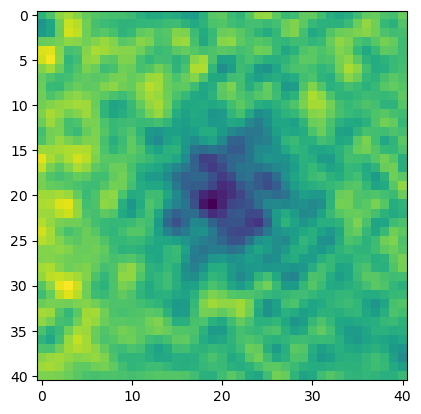

In [61]:
plt.imshow(images[2,0,...])

In [62]:
from torchvision.models import resnet18, ResNet18_Weights

model = resnet18(weights=ResNet18_Weights.DEFAULT)
#model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)


model.fc = nn.Linear(512, 2)
model = model.to(device)

In [63]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        #print(y)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            #print(pred)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [75]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(augmented_dataloader, model, loss_fn, optimizer)
    test_loop(val_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.057707  [    0/ 5872]
loss: 0.066508  [  640/ 5872]
loss: 0.084073  [ 1280/ 5872]
loss: 0.080279  [ 1920/ 5872]
loss: 0.080676  [ 2560/ 5872]
loss: 0.063138  [ 3200/ 5872]
loss: 0.183514  [ 3840/ 5872]
loss: 0.103876  [ 4480/ 5872]
loss: 0.053278  [ 5120/ 5872]
loss: 0.091826  [ 5760/ 5872]
Test Error: 
 Accuracy: 94.3%, Avg loss: 0.133185 

Epoch 2
-------------------------------
loss: 0.038230  [    0/ 5872]
loss: 0.109347  [  640/ 5872]
loss: 0.070491  [ 1280/ 5872]
loss: 0.083281  [ 1920/ 5872]
loss: 0.088843  [ 2560/ 5872]
loss: 0.054765  [ 3200/ 5872]
loss: 0.051837  [ 3840/ 5872]
loss: 0.062978  [ 4480/ 5872]
loss: 0.029957  [ 5120/ 5872]
loss: 0.059714  [ 5760/ 5872]
Test Error: 
 Accuracy: 95.5%, Avg loss: 0.129737 

Epoch 3
-------------------------------
loss: 0.042186  [    0/ 5872]
loss: 0.138051  [  640/ 5872]
loss: 0.031712  [ 1280/ 5872]
loss: 0.046288  [ 1920/ 5872]
loss: 0.034464  [ 2560/ 5872]
loss: 0.032745  [ 3200/ 58

In [50]:
test_loop(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 94.4%, Avg loss: 0.135855 



In [12]:


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(nchan, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
class test_Net(nn.Module):

    def __init__(self):
        super(test_Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(nchan, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)

        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(256, 64)  # 5*5 from image dimension
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class cifar_test_Net(nn.Module):

    def __init__(self):
        super(cifar_test_Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)

        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(256, 64)  # 5*5 from image dimension
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = test_Net()

In [13]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

In [14]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [15]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        #print(y)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            #print(pred)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [27]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(val_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.693437  [    0/ 4862]
loss: 0.692682  [  640/ 4862]
loss: 0.688887  [ 1280/ 4862]
loss: 0.692684  [ 1920/ 4862]
loss: 0.693431  [ 2560/ 4862]
loss: 0.691977  [ 3200/ 4862]
loss: 0.694814  [ 3840/ 4862]
loss: 0.695524  [ 4480/ 4862]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.693517 

Epoch 2
-------------------------------
loss: 0.690546  [    0/ 4862]
loss: 0.694796  [  640/ 4862]
loss: 0.691999  [ 1280/ 4862]
loss: 0.694794  [ 1920/ 4862]
loss: 0.694095  [ 2560/ 4862]
loss: 0.696863  [ 3200/ 4862]
loss: 0.693384  [ 3840/ 4862]
loss: 0.691324  [ 4480/ 4862]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.693590 

Epoch 3
-------------------------------
loss: 0.695430  [    0/ 4862]
loss: 0.692708  [  640/ 4862]
loss: 0.694021  [ 1280/ 4862]
loss: 0.692061  [ 1920/ 4862]
loss: 0.690791  [ 2560/ 4862]
loss: 0.696526  [ 3200/ 4862]
loss: 0.694622  [ 3840/ 4862]
loss: 0.692715  [ 4480/ 4862]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.693266 

Epoc

In [21]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        print(labels)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

tensor([0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
        1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
        0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0])
tensor([1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,
        1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0])
tensor([0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
        1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,
        0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0])
tensor([1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0,
        1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0,

[1,    40] loss: 0.003
tensor([1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0])
tensor([0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
        0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0])
tensor([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0,
        1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0])
tensor([1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0,
        1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
        1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0])
tensor([1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
        1, 0, 0, 1, 0, 0, 1, 

KeyboardInterrupt: 

In [19]:
test_loop(val_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 50.0%, Avg loss: 0.693157 



In [29]:
import torchvision.transforms as transforms
import torchvision

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [144]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [32]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.202
[1,  4000] loss: 1.839
[1,  6000] loss: 1.657
[1,  8000] loss: 1.554
[1, 10000] loss: 1.480
[1, 12000] loss: 1.389
[2,  2000] loss: 1.306
[2,  4000] loss: 1.257
[2,  6000] loss: 1.223
[2,  8000] loss: 1.173
[2, 10000] loss: 1.148
[2, 12000] loss: 1.107
Finished Training


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(trainloader, model, loss_fn, optimizer)
print("Done!")

Epoch 1
-------------------------------
loss: 2.060096  [    0/50000]
loss: 0.890363  [  400/50000]
loss: 0.372836  [  800/50000]
loss: 1.821747  [ 1200/50000]
loss: 0.707152  [ 1600/50000]
loss: 0.345539  [ 2000/50000]
loss: 0.877902  [ 2400/50000]
loss: 1.524981  [ 2800/50000]
loss: 2.065835  [ 3200/50000]
loss: 0.595890  [ 3600/50000]
loss: 1.007974  [ 4000/50000]
loss: 1.117746  [ 4400/50000]
loss: 0.597372  [ 4800/50000]
loss: 0.854401  [ 5200/50000]
loss: 1.041796  [ 5600/50000]
loss: 1.052626  [ 6000/50000]
loss: 1.214143  [ 6400/50000]
loss: 1.106204  [ 6800/50000]
loss: 0.805889  [ 7200/50000]
loss: 0.478496  [ 7600/50000]
loss: 0.453088  [ 8000/50000]
loss: 0.777674  [ 8400/50000]
loss: 0.684724  [ 8800/50000]
loss: 1.556073  [ 9200/50000]
loss: 0.855956  [ 9600/50000]
loss: 1.304052  [10000/50000]
loss: 0.975991  [10400/50000]
loss: 1.312486  [10800/50000]
loss: 0.939122  [11200/50000]
loss: 1.570962  [11600/50000]
loss: 1.059263  [12000/50000]
loss: 0.603696  [12400/50000]


loss: 0.742525  [ 8000/50000]
loss: 0.778277  [ 8400/50000]
loss: 1.118055  [ 8800/50000]
loss: 0.483934  [ 9200/50000]
loss: 1.168017  [ 9600/50000]
loss: 3.126446  [10000/50000]
loss: 0.204966  [10400/50000]
loss: 0.672307  [10800/50000]
loss: 0.938400  [11200/50000]
loss: 1.151416  [11600/50000]
loss: 0.302296  [12000/50000]
loss: 1.558384  [12400/50000]
loss: 1.100916  [12800/50000]
loss: 0.109435  [13200/50000]
loss: 1.966909  [13600/50000]
loss: 0.198178  [14000/50000]
loss: 3.015626  [14400/50000]
loss: 0.780849  [14800/50000]
loss: 1.495462  [15200/50000]
loss: 0.285534  [15600/50000]
loss: 0.262317  [16000/50000]
loss: 1.562996  [16400/50000]
loss: 2.144889  [16800/50000]
loss: 0.275759  [17200/50000]
loss: 0.508386  [17600/50000]
loss: 2.900773  [18000/50000]
loss: 0.261640  [18400/50000]
loss: 1.003810  [18800/50000]
loss: 0.680074  [19200/50000]
loss: 0.399111  [19600/50000]
loss: 0.417976  [20000/50000]
loss: 1.109479  [20400/50000]
loss: 1.602119  [20800/50000]
loss: 0.74

In [27]:
# Implementation of CNN/ConvNet Model
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # L1 ImgIn shape=(?, 28, 28, 1)
        # Conv -> (?, 28, 28, 32)
        # Pool -> (?, 14, 14, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        # L2 ImgIn shape=(?, 14, 14, 32)
        # Conv      ->(?, 14, 14, 64)
        # Pool      ->(?, 7, 7, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        # L3 ImgIn shape=(?, 7, 7, 64)
        # Conv ->(?, 7, 7, 128)
        # Pool ->(?, 4, 4, 128)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            torch.nn.Dropout(p=1 - keep_prob))

        # L4 FC 4x4x128 inputs -> 625 outputs
        self.fc1 = torch.nn.Linear(4 * 4 * 128, 625, bias=True)
        torch.nn.init.xavier_uniform(self.fc1.weight)
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - keep_prob))
        # L5 Final FC 625 inputs -> 10 outputs
        self.fc2 = torch.nn.Linear(625, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight) # initialize parameters

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.fc1(out)
        out = self.fc2(out)
        return out


#instantiate CNN model
model = CNN()
model

/tmp/ipykernel_3343235/3906010888.py:33: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (fc1): Linear(in_features=2048, out_features=625, bias=True)
  (layer4): Sequential(
    (0): Linear(in_features=2048, out_features=625, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
  )
  (fc2): Linear(in_features=625, out_features=10, bias=True)
)

In [28]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.333513  [    0/60000]
loss: 2.310068  [ 6400/60000]
loss: 2.273524  [12800/60000]
loss: 2.255716  [19200/60000]
loss: 2.244400  [25600/60000]
loss: 2.212022  [32000/60000]
loss: 2.213074  [38400/60000]
loss: 2.173571  [44800/60000]
loss: 2.146094  [51200/60000]
loss: 2.090101  [57600/60000]
Test Error: 
 Accuracy: 53.4%, Avg loss: 2.063510 

Epoch 2
-------------------------------
loss: 2.088126  [    0/60000]
loss: 2.029327  [ 6400/60000]
loss: 1.865700  [12800/60000]
loss: 1.799059  [19200/60000]
loss: 1.561360  [25600/60000]
loss: 1.439963  [32000/60000]
loss: 1.300343  [38400/60000]
loss: 1.148937  [44800/60000]
loss: 1.130939  [51200/60000]
loss: 1.039372  [57600/60000]
Test Error: 
 Accuracy: 68.7%, Avg loss: 0.964817 

Epoch 3
-------------------------------
loss: 1.035348  [    0/60000]
loss: 1.024850  [ 6400/60000]
loss: 0.736442  [12800/60000]
loss: 0.960207  [19200/60000]
loss: 0.845868  [25600/60000]
loss: 0.868031  [32000/600

KeyboardInterrupt: 

In [39]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [40]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [41]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [42]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [43]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [44]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        print(y)
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")